In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [27]:
from src.transformers.sklearn_model import SklearnModel
import gensim
from src.load_data import LoadData
from src.config import Config
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np
from scipy.stats import spearmanr
from matchms.filtering import add_fingerprint
import dill
from src.plotting import Plotting
from src.load_data import LoadData
from src.molecule_pairs_opt import MoleculePairsOpt
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
import pickle
import sys
from src.tanimoto import Tanimoto
from src.config import Config
from src.parser import Parser
from datetime import datetime
from ms2deepscore import MS2DeepScore
from src.loader_saver import LoaderSaver
from src.molecular_pairs_set import MolecularPairsSet
from scipy.stats import spearmanr
from src.transformers.embedder import Embedder
from src.transformers.encoder import Encoder
import matplotlib.pyplot as plt
from src.transformers.CustomDatasetEncoder import CustomDatasetEncoder
from src.transformers.load_data_encoder import LoadDataEncoder
from torch.utils.data import DataLoader
from src.analog_discovery.cosine_similarity import CosineSimilarity
from rdkit import Chem
from matchms.importing import load_from_mgf,load_from_msp
from matchms.similarity import ModifiedCosine
from src.spec2vec_comparison import Spec2VecComparison
from spec2vec import Spec2Vec
import tensorflow as tf
from ms2deepscore.models import load_model
from matchms.similarity import FingerprintSimilarity
from matchms.similarity import ModifiedCosine

## params

In [28]:
ls /Users/sebas/projects/data/

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_100_millions_more_epochs.ckpt
best_model_100_millions_more_epochs_day3.ckpt
best_model_1024n_10layers.ckpt
best_model_128n_10_layers_20240209.ckpt
best_model_128n_5_layers_20240219_elementwise.ckpt
best_model_128n_5_layers_20240229.ckpt
best_model_128n_5_layers_20240303.ckpt
best_model_150_millions.ckpt
best_model_20240301.ckpt
best_model_20240318_lib_cos_sim.ckpt
best_model_20240319_v2_512u_5_layers.ckpt
best_model_20240409_10_million_not_bining_sim_1.ckpt
best_model_20240409_1_million_not_bining_sim_1.ckpt
best_model_20240411_no_identity.ckpt
best_model_20240411_no_sim1.ckpt
best_model_20240507_100_millions_no_identity.ckpt
best_model_exhaustive_128n_20240522.ckpt
best_model_exhaustive_sampled_128n_20240523.ckpt
best_model_exhaustive_sampled_128n_20240523_with_pretrai

In [29]:
data_folder= '/Users/sebas/projects/data/'
gnps_path =  data_folder + 'ALL_GNPS_NO_PROPOGATED_wb.mgf'
mergeion_path = data_folder + 'drug_plus.mgf'
casmi_path = data_folder + 'processed_massformer/casmi2022.mgf'
nist_path = data_folder + 'hr_msms_nist_all.MSP'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
dataset_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'
model_path = data_folder + 'best_model_20240319_v2_512u_5_layers.ckpt'
model_spec2vec_file = data_folder + 'spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'
model_ms2d_file = data_folder + 'ms2deepscore_positive_10k_1000_1000_1000_500.hdf5'

In [30]:
config=Config()

In [31]:
config.D_MODEL=512
config.N_LAYERS=5

In [32]:
#similarity_name= 'spec2vec'
#similarity_name= 'spec2vec_casmi'
#similarity_name='ms2deepscore'
#similarity_name='ms2deepscore_casmi'
#similarity_name='modified_cosine'
#similarity_name='modified_cosine_casmi'
#similarity_name='tanimoto_similarity'
similarity_name='tanimoto_similarity_casmi'

In [33]:
USE_CASMI=True

In [65]:
OPEN_PREPROCESSED_DATA=False

## open janssen data

In [35]:
janssen_path = casmi_path if USE_CASMI else mergeion_path

In [36]:
all_spectrums_janssen_matchms = [s for s in load_from_mgf(janssen_path)]

In [37]:
len(all_spectrums_janssen_matchms)

170

In [38]:
loader_saver = LoaderSaver(
        block_size=100,
        pickle_nist_path='',
        pickle_gnps_path='',
        pickle_janssen_path=output_janssen_file,
    )

In [39]:
all_spectrums_janssen_su = loader_saver.get_all_spectrums(
            janssen_path,
            100000000,
            use_tqdm=True,
            use_nist=False,
            config=config,
            use_janssen=True,
        )

  0%|                                                                                                                                                                   | 170/100000000 [00:00<8:17:05, 3352.79it/s]

We reached the end of the array at index 170


In [40]:
len(all_spectrums_janssen_su)

170

## open ref data

In [41]:
with open(dataset_path, 'rb') as file:
            dataset = dill.load(file)

In [42]:
all_spectrums_reference_su= dataset['molecule_pairs_train'].spectrums_original +\
                    dataset['molecule_pairs_val'].spectrums_original + \
                        dataset['molecule_pairs_test'].spectrums_original

In [43]:
all_spectrums_gnps_matchms = [s for s in load_from_mgf(gnps_path)]

In [44]:
all_spectrums_nist_matchms=  [s for s in load_from_msp(nist_path)]

In [45]:
all_spectrums_reference_matchms = all_spectrums_gnps_matchms + all_spectrums_nist_matchms

In [46]:
#compute all the hashes from the datasets
target_hashes = [s.spectrum_hash for s in all_spectrums_reference_su]

In [47]:
matchms_hashes=[]
for s in  tqdm(all_spectrums_reference_matchms):
    matchms_hashes.append(s.spectrum_hash())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1531552/1531552 [01:00<00:00, 25211.95it/s]


In [48]:
len(target_hashes)

326386

In [49]:
len(all_spectrums_reference_matchms)

1531552

In [50]:
matchms_hashes.index(target_hashes[0])

3

In [51]:
indexes_matched = [matchms_hashes.index(t) for t in tqdm(target_hashes)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 326386/326386 [26:50<00:00, 202.67it/s]


In [52]:
all_spectrums_reference = [all_spectrums_reference_matchms[index] for index in indexes_matched]

In [53]:
for i,(s_ref, s_su) in enumerate(zip(all_spectrums_reference, all_spectrums_reference_su)):
    new_metadata=s_ref.metadata.copy()
    new_metadata['smiles']=s_su.smiles
    all_spectrums_reference[i].metadata=new_metadata

## Filter spectra from Janssen

In [54]:
su_hashes = [s.spectrum_hash for s in all_spectrums_janssen_su]

In [55]:
all_spectrums_janssen = [s for s in all_spectrums_janssen_matchms if s.spectrum_hash() in su_hashes]

## Find those instances that are not in reference

In [56]:
canon_smiles_reference = [Chem.CanonSmiles(s.metadata['smiles']) for s in all_spectrums_reference]
canon_smiles_janssen =   [Chem.CanonSmiles(s.metadata['smiles']) for s in all_spectrums_janssen]
janssen_indexes_in_ref= [i for i,s in enumerate(canon_smiles_janssen) if s in canon_smiles_reference]
janssen_indexes_not_in_ref = [i for i,s in enumerate(canon_smiles_janssen) if s not in canon_smiles_reference]

In [57]:
len(janssen_indexes_in_ref),len(janssen_indexes_not_in_ref)

(28, 142)

In [58]:
all_spectrums_janssen = [all_spectrums_janssen[index] for index in janssen_indexes_not_in_ref]

## load model

In [59]:
#encoder= Encoder(model_path, D_MODEL=int(config.D_MODEL),N_LAYERS=int(config.N_LAYERS))

In [60]:
#similarity_model =ModifiedCosine(tolerance=0.1)

In [61]:
if similarity_name.startswith('spec2vec'):
    model = gensim.models.Word2Vec.load(model_spec2vec_file)
    similarity_model= Spec2Vec(
                model=model, intensity_weighting_power=0.5, allowed_missing_percentage=100.0
            )
    PREPROCESS_SPECTRUMS=True
elif similarity_name.startswith('modified_cosine'):
    similarity_model =ModifiedCosine(tolerance=0.1)
    PREPROCESS_SPECTRUMS=False
elif similarity_name.startswith('ms2deepscore'):
    model_ms2d = load_model(model_ms2d_file)
    similarity_model= MS2DeepScore(model_ms2d)
elif similarity_name.startswith('tanimoto_similarity'):
    similarity_model=  FingerprintSimilarity(
                        similarity_measure="jaccard"
                    )
    PREPROCESS_SPECTRUMS=False

## Preprocessed spectrums

In [62]:
preprocessed_all_spectrums_janssen =all_spectrums_janssen.copy()
if PREPROCESS_SPECTRUMS:
    for i,s in tqdm(enumerate(preprocessed_all_spectrums_janssen)):
        preprocessed_all_spectrums_janssen[i] = Spec2VecComparison.spectrum_processing(preprocessed_all_spectrums_janssen[i])
preprocessed_all_spectrums_janssen = [s for s in preprocessed_all_spectrums_janssen if ((s is not None)and (s.metadata['precursor_mz']>0))]

In [63]:
len(preprocessed_all_spectrums_janssen)

142

In [66]:
if not(OPEN_PREPROCESSED_DATA):
    preprocessed_all_spectrums_reference =all_spectrums_reference.copy()
    if PREPROCESS_SPECTRUMS:
        for i,s in tqdm(enumerate(preprocessed_all_spectrums_reference)):
            preprocessed_all_spectrums_reference[i] = Spec2VecComparison.spectrum_processing(preprocessed_all_spectrums_reference[i])
        with open('preprocessed_all_spectrums_reference.pkl', 'wb') as file:
                dictionary={ 'all_spectrums_reference':all_spectrums_reference.copy(),
                             'preprocessed_all_spectrums_reference_ms2deepscore':all_spectrums_reference.copy(),
                            'preprocessed_all_spectrums_reference_spec2vec':preprocessed_all_spectrums_reference}
                dill.dump(dictionary,file)
else:
        with open('preprocessed_all_spectrums_reference.pkl', 'rb') as file:
            dictionary = dill.load(file)
        if PREPROCESS_SPECTRUMS:
            preprocessed_all_spectrums_reference = dictionary['preprocessed_all_spectrums_reference_ms2deepscore']
        else:
            preprocessed_all_spectrums_reference = dictionary['preprocessed_all_spectrums_reference_spec2vec']

In [67]:
#with open('preprocessed_all_spectrums_reference.pkl', 'wb') as file:
#                dictionary={ 'all_spectrums_reference':all_spectrums_reference.copy(),
#                             'preprocessed_all_spectrums_reference_ms2deepscore':all_spectrums_reference.copy(),
#                            'preprocessed_all_spectrums_reference_spec2vec':preprocessed_all_spectrums_reference}
#                dill.dump(dictionary,file)

In [68]:
# check that the preprocessed spectra is not empty and precursor mass >0
preprocessed_all_spectrums_janssen = [s for s in preprocessed_all_spectrums_janssen if ((s is not None)and (s.metadata['precursor_mz']>0))]
preprocessed_all_spectrums_reference = [s for s in preprocessed_all_spectrums_reference if ((s is not None)and (s.metadata['precursor_mz']>0))]


In [69]:
if similarity_name.startswith('ms2deepscore'):
    preprocessed_all_spectrums_janssen = [s for s in preprocessed_all_spectrums_janssen if s.mz[(s.mz >= 10) & (s.mz <= 1000)].shape[0]>0]
    preprocessed_all_spectrums_reference = [s for s in preprocessed_all_spectrums_reference if s.mz[(s.mz >= 10) & (s.mz <= 1000)].shape[0]>0]

In [70]:
len(preprocessed_all_spectrums_reference)

326383

In [71]:
len(preprocessed_all_spectrums_janssen)

142

In [72]:
preprocessed_all_spectrums_reference[0].spectrum_hash()

'bbb47d997208ea8660b0'

In [73]:
all_spectrums_reference[0].spectrum_hash()

'bbb47d997208ea8660b0'

## compute similarities

In [74]:
if similarity_name.startswith('tanimoto_similarity'):
    preprocessed_all_spectrums_janssen = [add_fingerprint(s) for s in preprocessed_all_spectrums_janssen] 
    preprocessed_all_spectrums_reference = [add_fingerprint(s) for s in preprocessed_all_spectrums_reference]

In [75]:
similarity_name

'tanimoto_similarity_casmi'

In [76]:
from matchms import calculate_scores


if similarity_name.startswith('ms2deepscore'):
    with tf.device('/device:CPU:0'): #execute on cpu
        results_scores = calculate_scores(
                        preprocessed_all_spectrums_reference, preprocessed_all_spectrums_janssen, similarity_model
                    )
else:
    results_scores = calculate_scores(
                        preprocessed_all_spectrums_reference, preprocessed_all_spectrums_janssen, similarity_model
                    )

In [77]:
results_scores

<326383x142x1 stacked sparse array containing scores for ('FingerprintSimilarity',) with 46338421 stored elements in COOrdinate format>

In [78]:
dir(results_scores)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_index',
 '_scores',
 '_validate_input_arguments',
 'calculate',
 'filter_by_range',
 'is_symmetric',
 'n_cols',
 'n_rows',
 'queries',
 'references',
 'score_names',
 'scores',
 'scores_by_query',
 'scores_by_reference',
 'shape',
 'to_array',
 'to_coo',
 'to_dict',
 'to_json',
 'to_pickle']

In [79]:
k=10
#results_tuple = [results_scores.scores_by_query(s, name='Spec2Vec', sort=True)[0:k] for s in preprocessed_all_spectrums_janssen]
results_tuple = [results_scores.scores_by_query(s, name='ModifiedCosine_score', sort=True)[0:k] for s in preprocessed_all_spectrums_janssen]

spectrums_retrieved = [  [r[0] for r in r_group] for r_group in results_tuple]
max_sim = [[r[1] for r in r_group] for r_group in results_tuple]

In [80]:
preprocessed_all_spectrums_janssen[0].spectrum_hash()

'ccc011f7d1775b8f48c5'

In [84]:
similarities_array= results_scores.to_array().transpose()

In [85]:
similarities_array.shape

(142, 326383)

In [87]:
## compute all similarities
similarities = np.zeros((len(preprocessed_all_spectrums_janssen),len(preprocessed_all_spectrums_reference)) )
for i,(s,sim_row) in enumerate(zip(preprocessed_all_spectrums_janssen, similarities_array)):
    #results_temp = results_scores.scores_by_query(s, name='ModifiedCosine_score', sort=False)
    similarities[i]=sim_row

In [89]:
#spectrums_retrieved = [results_scores.scores_by_query(s, name='Spec2Vec', sort=True)[0][0] \
#                       for s in preprocessed_all_spectrums_janssen]

In [90]:
#max_sim = [results_scores.scores_by_query(s, name='Spec2Vec', sort=True)[0][1] \
#                       for s in preprocessed_all_spectrums_janssen]

## Based on the similarities compute the similarity score of the match spectrum

In [91]:
smiles_retrieved = [[s.metadata['smiles'] for s in s_group] for s_group in spectrums_retrieved]

In [92]:
smiles_janssen =   [ s.metadata['smiles'] for s in preprocessed_all_spectrums_janssen]

In [93]:
from src.tanimoto import Tanimoto

In [94]:
tanimoto_retrieved = [[Tanimoto.compute_tanimoto_from_smiles(s0,s1) for s1 in s1_group] for s0, s1_group in zip(smiles_janssen, smiles_retrieved)]

In [95]:
best_index_retrieved = [np.argmax(t) for t in tanimoto_retrieved]
smiles_retrieved = [s_group[ind].metadata['smiles'] for ind,s_group in zip(best_index_retrieved,spectrums_retrieved)]
spectrums_retrieved = [s_group[ind] for ind,s_group in zip(best_index_retrieved,spectrums_retrieved)]
tanimoto_retrieved = [max(t) for t in tanimoto_retrieved]

In [96]:
#_=plt.hist(max_sim, color='r',bins=10)
#plt.xlabel('maximum predicted similarity found')
#plt.ylabel('freq')
#plt.grid()

Text(0, 0.5, 'frequency')

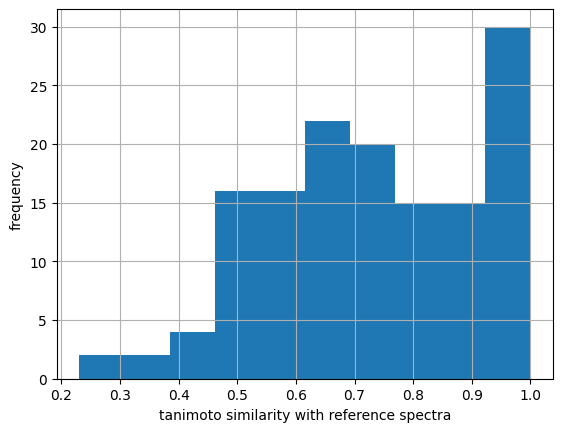

In [97]:
plt.hist(tanimoto_retrieved)
plt.grid()
plt.xlabel('tanimoto similarity with reference spectra')
plt.ylabel('frequency')

In [98]:
tanimoto_retrieved= np.array(tanimoto_retrieved)

In [99]:
#plt.scatter(tanimoto_retrieved, max_sim, alpha=0.5)
#plt.xlim([0,1])
#plt.ylim([0,1])
#plt.grid()
#plt.ylabel('prediction spec2vec')
#plt.xlabel('tanimoto')

## Check which is the spectra that has wrong predictions

In [100]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
def calculate_mcs_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    
    # Perform MCS (Maximum Common Substructure) search
    mcs = rdFMCS.FindMCS([mol1, mol2])

    # Get SMARTS pattern from MCS result
    mcs_smarts = Chem.MolToSmarts(mcs.queryMol)
    
    # Calculate Tanimoto-like similarity
    mcs_mol = Chem.MolFromSmarts(mcs_smarts)
    #mcs_count = len(Chem.GetMolFrags(mcs_mol))
    mcs_count = mcs_mol.GetNumAtoms()
    similarity = mcs_count / (mol1.GetNumAtoms() + mol2.GetNumAtoms() - mcs_count)

    return similarity, mcs_mol
from rdkit.Chem import rdRascalMCES
def calculate_mces_sim(smiles1, smiles2, similarity_threshold=0.7):

    ad1 = Chem.MolFromSmiles(smiles1)
    ad2 = Chem.MolFromSmiles(smiles2)
    opts = rdRascalMCES.RascalOptions()
    opts.similarityThreshold = similarity_threshold
    opts.returnEmptyMCES = True
    results = rdRascalMCES.FindMCES(ad1, ad2, opts)
    if len(results) != 0:
        similarity_tier1= results[0].tier1Sim
        similarity_tier2= results[0].tier2Sim
    
        if similarity_tier2 != -1:
            return similarity_tier2 #if the lower threshold is not surpassed
        else:
            return similarity_tier1
    else:
        return None

In [101]:
len(all_spectrums_janssen)

142

In [102]:
len(spectrums_retrieved)

142

In [103]:
#bad_predictions = np.argsort(abs(tanimoto_retrieved-max_sim))[::-1]

In [104]:
#target_spectra=bad_predictions[3]

In [105]:
#max_sim[target_spectra]

In [106]:
#tanimoto_retrieved[target_spectra]

In [107]:
## mcs
#sim_mcs, mol_mcs=calculate_mcs_similarity(smiles1=all_spectrums_janssen[target_spectra].metadata['smiles'], 
#                         smiles2=spectrums_retrieved[target_spectra].metadata['smiles'])
#sim_mcs

In [108]:
#spectrums_retrieved[target_spectra].plot_against(all_spectrums_janssen[target_spectra])
#plt.xlim(0, 100)

In [109]:
#sim_mces = calculate_mces_sim(smiles1=all_spectrums_janssen[target_spectra].metadata['smiles'], 
 #smiles2=spectrums_retrieved[target_spectra].metadata['smiles'])
#sim_mces

In [110]:
#mol_mcs

In [111]:
## plot the molecules

In [112]:
#Chem.CanonSmiles(all_spectrums_janssen[target_spectra].metadata['smiles'])

In [113]:
#from rdkit import Chem
#mol_janssen = Chem.MolFromSmiles(all_spectrums_janssen[target_spectra].metadata['smiles'])
#mol_janssen

In [114]:
#Chem.CanonSmiles(spectrums_retrieved[target_spectra].metadata['smiles'])

In [115]:
#mol_ref = Chem.MolFromSmiles(spectrums_retrieved[target_spectra].metadata['smiles'])
#mol_ref

## FIND SIMILARITY BASED ON MCS

In [116]:
len(smiles_retrieved)

142

In [117]:
len(smiles_janssen)

142

In [118]:
mces_sims=[]
for s0,s1 in tqdm(zip(smiles_janssen, smiles_retrieved)):
    similarity= calculate_mces_sim(s0, s1)
    mces_sims.append(similarity)

0it [00:00, ?it/s]Too many matching bond pairs (1114) so can't continue.
48it [00:00, 171.37it/s]Too many matching bond pairs (1020) so can't continue.
Too many matching bond pairs (1076) so can't continue.
Too many matching bond pairs (1348) so can't continue.
Too many matching bond pairs (1177) so can't continue.
Too many matching bond pairs (1353) so can't continue.
Too many matching bond pairs (2859) so can't continue.
142it [00:00, 351.14it/s]


In [119]:
# Specify the bin width
bin_width = 0.1

# Calculate the number of bins based on the data range and bin width
bins = np.arange(0, 1 + bin_width, bin_width)

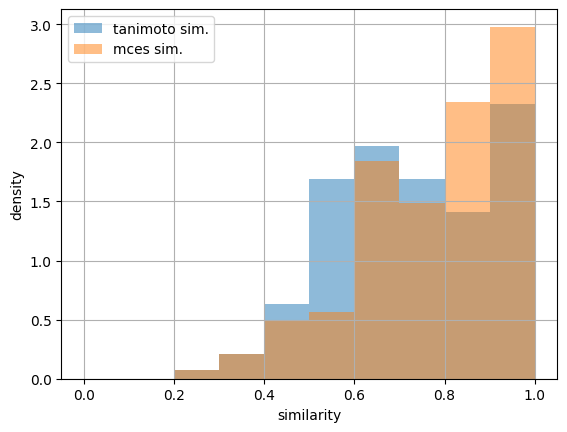

In [120]:
plt.hist(tanimoto_retrieved,alpha=0.5, label='tanimoto sim.', density=True, bins=bins)
plt.hist([m for m in mces_sims if m is not None],alpha=0.5, label='mces sim.', density=True, bins=bins)
plt.xlabel('similarity')
plt.ylabel('density')
plt.legend()
plt.grid()

## Get the best candidate results

In [121]:
format_file_unknown = "./notebooks/discovery_search/results/{}_results_analog_discovery_unknwon_compounds.pkl"

if USE_CASMI:
    file= format_file_unknown.format('tanimoto_similarity_casmi')
else:
    file= format_file_unknown.format('tanimoto_similarity')
with open(file, 'rb') as f:
        results_tani = dill.load(f)

In [122]:
results_tani.keys()

dict_keys(['preprocessed_all_spectrums_janssen', 'original_all_spectrums_janssen', 'smiles_janssen', 'smiles_retrieved', 'spectrums_retrieved', 'original_spectrums_retrieved', 'tanimoto_retrieved', 'max_sim', 'mces_retrieved'])

In [123]:
similarities.shape

(142, 326383)

In [126]:
#len(smiles_reference)

In [127]:
smiles_best_candidate=results_tani['smiles_retrieved']

In [128]:
len(smiles_best_candidate)

142

In [129]:
## get the indexes in the reference data
smiles_best_candidate = [Chem.CanonSmiles(s) for s in smiles_best_candidate]
smiles_reference = [Chem.CanonSmiles(spec.metadata['smiles']) for spec in preprocessed_all_spectrums_reference]

In [130]:
list_indexes_best_candidate = [[i for i,s2 in enumerate(smiles_reference) if s==s2] for s in smiles_best_candidate]

In [131]:
def get_rankings(similarities, smiles_reference, smiles_best_candidate, ):
    argsort_similarities = np.argsort(-similarities, axis=1)
    list_indexes_best_candidate = [[i for i,s2 in enumerate(smiles_reference) if s==s2] for s in smiles_best_candidate]
    
    list_rankings=[]
    for index_row,sim_row  in zip(list_indexes_best_candidate, argsort_similarities):
        rank = min([(np.argwhere(sim_row==item)[0][0]) for item in index_row])
        list_rankings.append(rank)

    return list_rankings

In [132]:
list_rankings = get_rankings(similarities, smiles_reference, smiles_best_candidate,)

## saving of results

In [133]:
def get_identifier(s):
    if 'nistno' in s.metadata:
        return(s.metadata['nistno'])
    elif 'spectrum_id' in s.metadata:
        return (s.metadata['spectrum_id'])

In [134]:
all_spectrums_ref_identifiers =[]
for s in all_spectrums_reference:
    ident = get_identifier(s)
    all_spectrums_ref_identifiers.append(ident)

In [135]:
all_spectrums_retrieved_identifiers =[]
for s in spectrums_retrieved:
    ident = get_identifier(s)
    all_spectrums_retrieved_identifiers.append(ident)

In [136]:
original_spectrums_retrieved = [all_spectrums_reference[all_spectrums_ref_identifiers.index(ident)] for s,ident in zip(spectrums_retrieved, all_spectrums_retrieved_identifiers)]

In [137]:
len(original_spectrums_retrieved)

142

In [138]:
results ={ 'preprocessed_all_spectrums_janssen':preprocessed_all_spectrums_janssen,
          'original_all_spectrums_janssen':all_spectrums_janssen,
            'smiles_janssen':smiles_janssen,
          'smiles_retrieved':smiles_retrieved,
          'spectrums_retrieved':spectrums_retrieved,
          'original_spectrums_retrieved':original_spectrums_retrieved,
            'tanimoto_retrieved':tanimoto_retrieved,
          'max_sim':max_sim,
          'mces_retrieved':mces_sims,
         'similarities': similarities,
         'list_rankings': list_rankings,
          'preprocessed_all_spectrums_reference':preprocessed_all_spectrums_reference,
          'smiles_reference':smiles_reference,
         }

In [139]:
with open('./notebooks/discovery_search/results/'+similarity_name + '_results_analog_discovery_unknwon_compounds.pkl', 'wb') as f:
    dill.dump(results, f)

## check what are the characteristics of the spectrums retrieved

In [140]:
spectrums_retrieved

[Spectrum(precursor m/z=515.19, 7 fragments between 85.0 and 515.2),
 Spectrum(precursor m/z=352.17, 13 fragments between 58.1 and 352.2),
 Spectrum(precursor m/z=435.22, 10194 fragments between 44.9 and 1504.9),
 Spectrum(precursor m/z=539.20, 19 fragments between 172.1 and 456.5),
 Spectrum(precursor m/z=503.34, 15 fragments between 221.2 and 504.3),
 Spectrum(precursor m/z=419.28, 60 fragments between 81.1 and 421.3),
 Spectrum(precursor m/z=375.09, 16 fragments between 149.0 and 375.1),
 Spectrum(precursor m/z=472.07, 10 fragments between 117.0 and 473.1),
 Spectrum(precursor m/z=475.21, 32 fragments between 56.0 and 476.2),
 Spectrum(precursor m/z=232.17, 15 fragments between 55.1 and 232.2),
 Spectrum(precursor m/z=475.21, 7 fragments between 58.1 and 476.2),
 Spectrum(precursor m/z=256.30, 6 fragments between 57.1 and 257.3),
 Spectrum(precursor m/z=251.16, 100 fragments between 55.0 and 251.2),
 Spectrum(precursor m/z=229.11, 71 fragments between 51.0 and 167.1),
 Spectrum(prec

In [141]:
spectrums_retrieved[5].metadata

{'charge': 1,
 'ionmode': 'positive',
 'smiles': 'CCC1=C(C)C(C(C)=C(C(C)C(O)C(C2=C(C)C(C(C)C(C(CC)C)O2)=O)C)O1)=O',
 'scans': '3530',
 'ms_level': '2',
 'instrument_type': 'LC-ESI-qTof',
 'file_name': 'f.negarg/160Gatech/Sponge_positive_5uL_P1-D-1_01_422.mzXML;',
 'peptide_sequence': '*..*',
 'organism_name': 'GNPS-LIBRARY',
 'compound_name': 'Putative smenopyrone M+H',
 'principal_investigator': 'Neha Garg',
 'data_collector': 'Neha Garg',
 'submit_user': 'negarg',
 'confidence': '3',
 'spectrum_id': 'CCMSLIB00004752863',
 'precursor_mz': 419.279,
 'fingerprint': array([0, 0, 1, ..., 1, 1, 0])}

In [142]:
bad_indexes= np.argsort(tanimoto_retrieved)[0:20]
good_indexes= [index for index in range(0, len(tanimoto_retrieved)) if index not in bad_indexes]

In [143]:
bad_spectrums=[spectrums_retrieved[index] for index in bad_indexes ]
good_spectrums=[spectrums_retrieved[index] for index in good_indexes ]

In [144]:
is_gnps_bad_spectrums = [s for s in bad_spectrums if 'spectrum_id' in s.metadata]
is_gnps_good_spectrums = [s for s in good_spectrums if 'spectrum_id' in s.metadata]

In [145]:
len(is_gnps_bad_spectrums)/len(bad_spectrums)

0.55

In [146]:
len(is_gnps_good_spectrums)/len(good_spectrums)

0.4016393442622951

## pass the same bad spectrum used in simba here

In [147]:
len(preprocessed_all_spectrums_janssen)

142

In [148]:
len(preprocessed_all_spectrums_reference)

326383

In [149]:
target_spectrum_janssen = [s for s in preprocessed_all_spectrums_janssen if s.metadata['id']=='CUIHSIWYWATEQL'][0]

IndexError: list index out of range

In [ ]:
target_spectrum_janssen

In [ ]:
target_spectrum_ref = [s for s in preprocessed_all_spectrums_reference if 'spectrum_id' in s.metadata]
target_spectrum_ref = [s for s in target_spectrum_ref if s.metadata['spectrum_id']=='CCMSLIB00003134614'][0]

In [ ]:
target_spectrum_ref

In [ ]:
target_results=calculate_scores( [target_spectrum_ref], [target_spectrum_janssen], similarity_model
                    )

In [ ]:
target_results.scores_by_query(target_spectrum_janssen, name='Spec2Vec', sort=True)

## what I got when I run the model?

In [ ]:
results_scores.scores_by_query(target_spectrum_janssen, name='Spec2Vec', sort=True)

In [ ]:
spectrums_retrieved